In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from statsmodels.tsa import stattools
from IPython.display import HTML
import datetime
import seaborn as sns

PROJ_PATH = '/home/anthony/personalSite/content/project/internet-traffic/'
pd.set_option('max_colwidth', 1000)

%run ./ping_helps.ipynb
%run ./graph_helps.ipynb

clean = read_all()

clean['hour'] = clean['tstamp'].apply(lambda x: x.hour)
clean['day'] =  clean['tstamp'].apply(lambda x: x.isoweekday())  

TICK_SIZE = 10
LAB_SIZE = 15

DOW_MAP = {1:'Monday',
           2:'Tuesday',
           3:'Wednesday',
           4:'Thursday',
           5:'Friday',
           6:'Saturday',
           7:'Sunday'
}

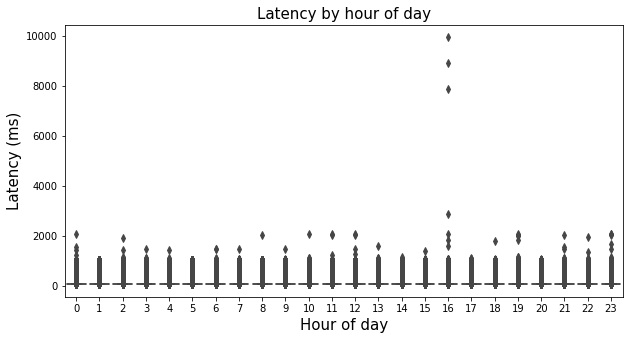

In [2]:
sns.boxplot(x='hour', y='lat', data=clean);
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(10)
plt.xlabel('Hour of day', fontsize=LAB_SIZE)
plt.ylabel('Latency (ms)', fontsize=LAB_SIZE)
plt.title('Latency by hour of day', fontsize=LAB_SIZE)
plt.savefig(PROJ_PATH+'yikes.png')

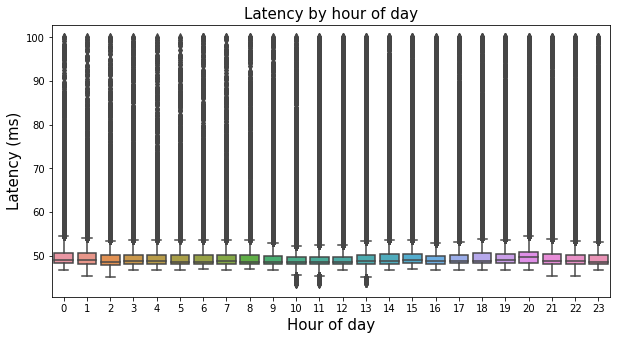

In [3]:
sns.boxplot(x='hour', y='lat', data=clean[clean['lat'] <= 100]);
plt.gcf().set_figheight(5)
plt.gcf().set_figwidth(10)
plt.xlabel('Hour of day', fontsize=LAB_SIZE)
plt.ylabel('Latency (ms)', fontsize=LAB_SIZE)
plt.title('Latency by hour of day', fontsize=LAB_SIZE)
plt.savefig(PROJ_PATH+'fix.png')

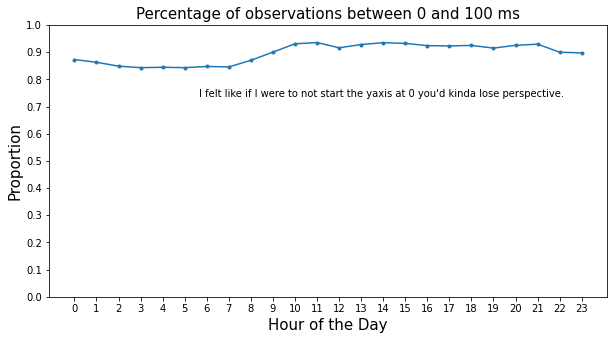

In [4]:
rels = group_block(clean, 'hour', 'lat', np.arange(0, 1100, 100))
START = 0
END = 100

rels[rels.index.get_level_values(None) == pd.Interval(START, END)].plot(use_index=False, style='.-');

annot = 'I felt like if I were to not start the yaxis at 0 you\'d kinda lose perspective.'
plt.annotate(annot, xy = (150,200), xycoords = 'axes pixels')
plt.title(label=f'Percentage of observations between {START} and {END} ms', fontsize=LAB_SIZE)

plt.xlabel('Hour of the Day', fontsize=LAB_SIZE);
plt.xticks(np.arange(24));

plt.ylim((0, 1));
plt.yticks(np.arange(0, 1.1, .1));
plt.ylabel('Proportion', fontsize=LAB_SIZE)

plt.gcf().set_figheight(5);
plt.gcf().set_figwidth(10);
plt.savefig(PROJ_PATH+'hour.png')

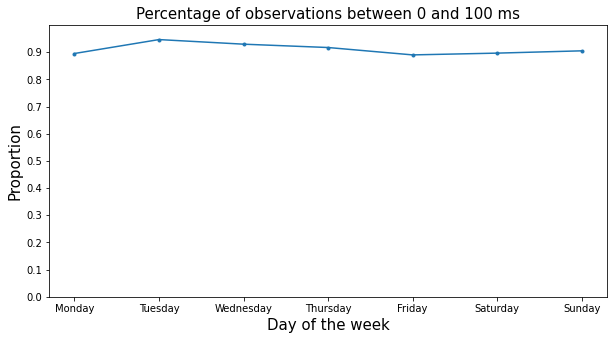

In [5]:
rels = group_block(clean, 'day', 'lat', np.arange(0, 1100, 100))
START = 0
END = 100

rels[rels.index.get_level_values(None) == pd.Interval(START, END)].plot(use_index=False, 
                                                                        kind='line', style='.-');

plt.title(label=f'Percentage of observations between {START} and {END} ms', fontsize=LAB_SIZE);

plt.xticks(rels.index.levels[0].values - 1, 
           rels.index.levels[0].map(DOW_MAP));
plt.yticks(np.arange(0, 1, .1));

plt.xlabel('Day of the week', fontsize=LAB_SIZE);
plt.ylabel('Proportion', fontsize=LAB_SIZE)

plt.ylim((0, 1));

plt.gcf().set_figheight(5);
plt.gcf().set_figwidth(10);
plt.savefig(PROJ_PATH+'day.png')